# Sentinel-1 Cumulative Sum Analysis to Map Forest Disturbances

#### Code by Chiara Aquino
#### Modified by Rajat Dhane


In [ ]:
# # #import earth engine API.
import ee

# # Authenticate and Initialise.
# # Authenticate the user with their Google account.
ee.Authenticate()

# # Initialize the connection to the Earth Engine servers.
ee.Initialize()

In [ ]:
# Install the libraries if required
!pip install geemap
!pip install os
!pip install xarray
!pip install rioxarray
!pip install pyshp
!pip install pycrs
!pip install glob2

In [3]:
# Import all necessary libraries
import geemap # interactive mapping with Google Earth Engine
import os  # interacting with the operating system
import xarray as xr # working with labelled multi-dimensional arrays
import rioxarray  # extension to xarray for working with geospatial data
import numpy as np  # functionality for large arrays and matrices of numeric data
import glob2 as glob # finding files matching a specified pattern in a directory
import datetime   # provides classes for working with dates and times in Python
import pandas as pd  # provides data structures for efficiently storing and manipulating large datasets
#import pyshp # reading and writing shapefiles
import pycrs # working with Coordinate Reference Systems (CRS)

#### Image Processing Functions

In [4]:
# for VV polarisation
#convert from sigma_0 to gamma_0
def toGamma0_VV(image):
  gamma0 = image.select('VV').subtract(image.select('angle').multiply(np.pi/180.0).cos().log10().multiply(10.0));
  return gamma0.copyProperties(image).copyProperties(image,['system:time_start']);

# for VH polarisation
#convert from sigma_0 to gamma_0
def toGamma0_VH(image):
  gamma0 = image.select('VH').subtract(image.select('angle').multiply(np.pi/180.0).cos().log10().multiply(10.0));
  return gamma0.copyProperties(image).copyProperties(image,['system:time_start']);

# mosaic images with the same date that have been spatially split
def mosaicByDate(imcol):
    imlist = imcol.toList(imcol.size())
    unique_dates = imlist.map(lambda im: ee.Image(im).date().format("YYYY-MM-dd")).distinct()
    def mosaic_imlist(d):
        d = ee.Date(d)
        im = imcol.filterDate(d, d.advance(1, "day")).mosaic()
        return im.set(
        "system:time_start", d.millis(),
        "system:id", d.format("YYYY-MM-dd"));
    return ee.ImageCollection(unique_dates.map(mosaic_imlist))

#### Define input parameters

In [5]:
# define year of the analysis
# year = 2020
year = 2022;
START_DATE = str(year-1)+"-01-01"; #no image before
END_DATE = str(year+1)+"-07-01"; #exclusive = ie., until 2021-06-31

# define image projection
crs = "EPSG:4326"

In [6]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# define your area of interest
aoi_shp = "/content/drive/My Drive/AOI/AOI_Extent.shp"
aoi = geemap.shp_to_ee(aoi_shp)

# choose a path for your output directory. This is where you will have saved all the images in the collection
outdir_vv = "/content/drive/My Drive/Cusum_data/DSC_VV/" # for VV data

outdir_vh = "/content/drive/My Drive/Cusum_data/DSC_VH/" # for VH data

#### Download Image Collection


In [8]:
# image collection for VV polarisation
collection = (ee.ImageCollection('COPERNICUS/S1_GRD')
          .filterBounds(aoi).filterDate(ee.Date(START_DATE), ee.Date(END_DATE))
          .filter(ee.Filter.eq('instrumentMode', 'IW'))
          .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
          .filterMetadata('transmitterReceiverPolarisation', 'equals', ['VV', 'VH'])
          .filterMetadata('resolution_meters', 'equals', 10)
          .map(toGamma0_VV)
          .map(lambda image:image.clip(aoi.geometry())))

# select VV polarization
vv = collection.select(['VV'])

#Number of images in the collection
vv_size = vv.size().getInfo()
print('original size of Image Stack VV: ', vv_size)

# Converts the vv ImageCollection to a list of individual images.
imlist = vv.toList(vv.size())

# Extracts the acquisition dates of each image in the vv ImageCollection, formats
unique_dates = imlist.map(lambda im:ee.Image(im).date().format("YYYY-MM-dd")).distinct()

# converts the unique_dates list to a Python list (i.e., from an Earth Engine
date_list = unique_dates.getInfo()

# mosaic images with same date for VV
vv_mosaic = mosaicByDate(vv)

# the number of images in the collection after mosaicking
mosaic_size = vv_mosaic.size().getInfo()
print('size of Image Stack after mosaicking: ' ,mosaic_size)

# RUN ONLY FOR FIRST TIME Whn you want to download the data
# exports the vv_mosaic ImageCollection as individual image files to Google Drive
# geemap.ee_export_image_collection(vv_mosaic, scale=10,out_dir=outdir_vv, region=aoi.geometry(),crs=crs)

original size of Image Stack VV:  75
size of Image Stack after mosaicking:  75


In [9]:
# image collection for VH polarisation
collection = (ee.ImageCollection('COPERNICUS/S1_GRD')
          .filterBounds(aoi).filterDate(ee.Date(START_DATE), ee.Date(END_DATE))
          .filter(ee.Filter.eq('instrumentMode', 'IW'))
          .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
          .filterMetadata('transmitterReceiverPolarisation', 'equals', ['VV', 'VH'])
          .filterMetadata('resolution_meters', 'equals', 10)
          .map(toGamma0_VH)
          .map(lambda image:image.clip(aoi.geometry())))

# select VH polarization
vh = collection.select(['VH'])
vh_size = vv.size().getInfo()
print('original size of Image Stack VH: ', vh_size)

#get image dates for VH
imlist = vh.toList(vh.size())
unique_dates = imlist.map(lambda im:ee.Image(im).date().format("YYYY-MM-dd")).distinct()
date_list = unique_dates.getInfo()

#mosaic images with same date for VH
vh_mosaic = mosaicByDate(vh)
mosaic_size = vh_mosaic.size().getInfo()
print('size of Image Stack after mosaicking: ' ,mosaic_size)

# RUN ONLY FOR FIRST TIME Whn you want to download the data
# export Image Collection to your folder
# geemap.ee_export_image_collection(vh_mosaic, scale=10,out_dir=outdir_vh, region=aoi.geometry(),crs=crs)

original size of Image Stack VH:  75
size of Image Stack after mosaicking:  75


#### Convert Image Collection to xarray

In [10]:
# lists all files in the output directory
vv_tifs = os.listdir(outdir_vv)

# creates a list of files with the ".tif" extension in the output directory.
files_vv = list(filter(os.path.isfile, glob.glob(outdir_vv + "*.tif")))

# sort images by download time for VV
files_vv.sort(key=lambda x: os.path.getctime(x))

# loop through the list, open image as xarray and assign time label
list_da_vv=[]
for file, date in zip(files_vv, date_list):

    # masked=True to ensure that the data is read as a masked array,
    da = rioxarray.open_rasterio(file,masked=True)

    # onverts the date string into a datetime object
    dt = datetime.datetime.strptime(date,"%Y-%m-%d")

    # datetime object is then converted into a Pandas Timestamp
    dt = pd.to_datetime(dt)

    # assigned the time coordinate
    da = da.assign_coords(time = dt)

    # expanded to add a new time dimension
    da = da.expand_dims(dim="time")
    list_da_vv.append(da)

# combines multiple DataArrays into a single Dataset object along their coordinates.
ds_vv = xr.combine_by_coords(list_da_vv)

In [11]:
# list all downloaded images of VH
vh_tifs = os.listdir(outdir_vh)
files_vh = list(filter(os.path.isfile, glob.glob(outdir_vh + "*.tif")))

#sort images by download time for VV
files_vh.sort(key=lambda x: os.path.getctime(x))

# loop through the list, open image as xarray and assign time label
list_da_vh=[]

# zip() function is used to iterate over the two lists simultaneously
for file, date in zip(files_vh, date_list):
    da = rioxarray.open_rasterio(file,masked=True)
    dt = datetime.datetime.strptime(date,"%Y-%m-%d")
    dt = pd.to_datetime(dt)
    da = da.assign_coords(time = dt)
    da = da.expand_dims(dim="time")
    list_da_vh.append(da)

#stack data arrays in list
ds_vh = xr.combine_by_coords(list_da_vh)

#### CumSum implementation

In [54]:
# get timeseries mean
ds_vv_mean = ds_vv.mean(dim='time')

ds_vh_mean = ds_vh.mean(dim='time')

#get time series residual
R_vv = ds_vv - ds_vv_mean

R_vh = ds_vh - ds_vh_mean

# get time series cumulative sum
S_vv = R_vv.cumsum(dim="time")

S_vh = R_vh.cumsum(dim="time")

# get maximum of the cumulative sum
Smax_vv= S_vv.max(dim="time")
Smax_vh= S_vh.max(dim="time")

Smax = xr.concat([Smax_vv, Smax_vh], dim='time')

# Calculate the threshold as the 95th percentile
threshold = np.percentile(Smax, 95)

# filter cumulative sum array by year of interest
Sfilt_time = S_vv[S_vv['time.year']==year]

# convert to DOY
Sfilt_time['time'] = Sfilt_time["time.dayofyear"]

# sets all values in the Sfilt_time dataset that are less than the threshold
Sfilt_n = Sfilt_time.where(Sfilt_time>= threshold,np.nan)

# creates a mask by selecting the first time slice of the Sfilt_n dataset
mask = Sfilt_n['time'].isel(time=0).notnull()

# convert Nan to calculate maximum
Sfilt_n2 = Sfilt_n.fillna(-9999)

# get the date where the curve reaches the maximum value
Sfilt_max = Sfilt_n2.isel(time = Sfilt_n2.argmax('time')).where(mask)

# NaN values in locations where there is no valid data.
max_values = Sfilt_max.where(Sfilt_max> -9999,np.nan)

# max cusum along the time dimension
max_dates = Sfilt_n.idxmax(dim="time")

# maximum cumulative sum value
max_values.name = 'Smax'

#  the day of the year of the maximum cumulative sum value
max_dates.name = 'doy'

SAVE OUTPUT

In [55]:
intensityName = '/content/drive/My Drive/Cusum_output/Comb_Smax_95.tif'   # path to your folder for Smax intensity image
dateName = '/content/drive/My Drive/Cusum_output/Comb_Dates_95.tif'       # path to your folder for Date image

# write the coordinate reference system to the data arrays for export.
max_values_raster = max_values.rio.write_crs(crs)
max_values_raster.rio.to_raster(intensityName)

max_dates_raster = max_dates.rio.write_crs(crs)
max_dates_raster.rio.to_raster(dateName)

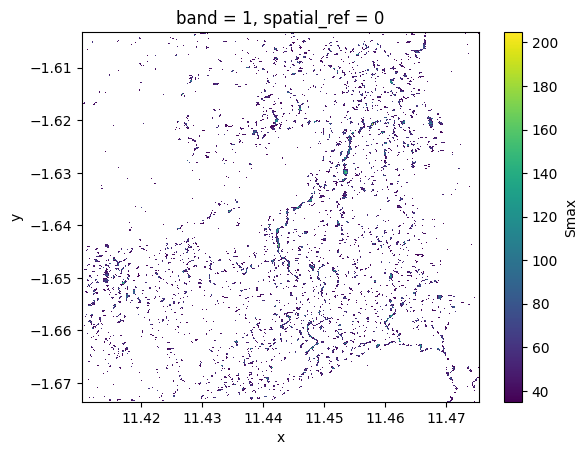

In [56]:
max_values.plot()

CUSUM STANDARDIZED

In [59]:
# get timeseries mean
ds_vv_mean = ds_vv.mean(dim='time')

ds_vh_mean = ds_vh.mean(dim='time')

# standard deviation of the entire time series
std_vv = ds_vv.std(dim='time')

std_vh = ds_vh.std(dim='time')

# Standardize data with z-score normalization
ds_vv_std = (ds_vv - ds_vv_mean) / std_vv

ds_vh_std = (ds_vh - ds_vh_mean) / std_vh

# get time series cumulative sum
S_vv_n = ds_vv_std.cumsum(dim="time")

S_vh_n = ds_vv_std.cumsum(dim="time")

# get maximum of the cumulative sum
Smax_vv_n= S_vv_n.max(dim="time")
Smax_vh_n= S_vh_n.max(dim="time")

# combine both of the cusum max
Smax = xr.concat([Smax_vv_n, Smax_vh_n], dim='time')

# Calculate the threshold as the 95th percentile
threshold = np.percentile(Smax, 95)

# filter cumulative sum array by year of interest
Sfilt_time = S_vv_n[S_vv_n['time.year']==year]

# convert to DOY
Sfilt_time['time'] = Sfilt_time["time.dayofyear"]

# sets all values in the Sfilt_time dataset that are less than the threshold
Sfilt_n = Sfilt_time.where(Sfilt_time>= threshold,np.nan)

# creates a mask by selecting the first time slice of the Sfilt_n dataset
mask = Sfilt_n['time'].isel(time=0).notnull()

# convert Nan to calculate maximum
Sfilt_n2 = Sfilt_n.fillna(-9999)

# get the date where the curve reaches the maximum value
Sfilt_max = Sfilt_n2.isel(time = Sfilt_n2.argmax('time')).where(mask)

# NaN values in locations where there is no valid data.
max_values1 = Sfilt_max.where(Sfilt_max> -9999,np.nan)

# max cusum along the time dimension
max_dates1 = Sfilt_n.idxmax(dim="time")

# maximum cumulative sum value
max_values1.name = 'Smax'

#  the day of the year of the maximum cumulative sum value
max_dates1.name = 'doy'

In [52]:
intensityName = '/content/drive/My Drive/Cusum_output/Comb_NS_Smax_95.tif'   # path to your folder for Smax intensity image
dateName = '/content/drive/My Drive/Cusum_output/Comb_NS_Dates_95.tif'       # path to your folder for Date image

# write the coordinate reference system to the data arrays for export.
max_values_raster1 = max_values1.rio.write_crs(crs)

# methods to export the GeoTIFF files with the compressed format of LZMA.
max_values_raster1.rio.to_raster(intensityName)

max_dates_raster1 = max_dates1.rio.write_crs(crs)
max_dates_raster1.rio.to_raster(dateName)

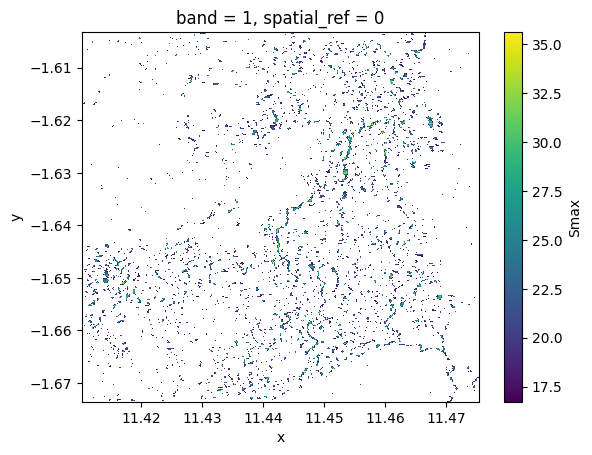

In [60]:
max_values1.plot()